In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
'''from google.colab import files'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/mohs_announcement.csv"
df = pd.read_csv(data,header= 0)
df.insert(loc=0, column="case_id", value=np.arange(1,len(df)+1))
df["case_id"] = "case_" + df["case_id"].astype(str)
df["first_date"] = pd.to_datetime(df["first_date"])
df["qua_date"] = pd.to_datetime(df["qua_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["exp_date"] = pd.to_datetime(df["exp_date"])
df

,case_id,age,sex,travel,region,first_date,qua_date,ann_date,exp_date
0,case_1,36,Male,United States,Chin,2020-03-13,2020-03-21,2020-03-23,NaT
1,case_2,26,Male,United Kingdom,Yangon,2020-03-22,2020-03-23,2020-03-23,NaT
2,case_3,26,Male,United Kingdom,Yangon,2020-03-21,2020-03-23,2020-03-25,NaT
3,case_4,33,Male,United States of America,Yangon,2020-03-19,2020-03-25,2020-03-27,NaT
4,case_5,69,Male,Australia -> Singapore,Yangon,2020-03-14,2020-03-25,2020-03-27,2020-03-31
5,case_6,29,Male,United Kingdom,Yangon,2020-03-21,2020-03-26,2020-03-28,NaT
6,case_7,58,Female,Switzerland,Nay Pyi Taw,2020-03-18,2020-03-26,2020-03-28,NaT
7,case_8,60,Female,NaN,Yangon,2020-03-25,2020-03-26,2020-03-28,NaT
8,case_9,44,Male,Thailand,Yangon,2020-03-23,2020-03-26,2020-03-29,NaT
9,case_10,45,Male,NaN,Yangon,2020-03-28,2020-03-28,2020-03-29,NaT


In [3]:
case_df = df[["ann_date","case_id"]].copy()
case_df.columns = ["date", "case"]
case_df=case_df.groupby(["date"]).size().to_frame('new_case').reset_index()
case_df["date"] = pd.to_datetime(case_df["date"])
case_df

,date,new_case
0,2020-03-23,2
1,2020-03-25,1
2,2020-03-27,2
3,2020-03-28,3
4,2020-03-29,2
5,2020-03-30,5
6,2020-04-01,1
7,2020-04-02,4
8,2020-04-04,1


In [4]:
pred_df = pd.DataFrame(columns=["ndays","date"])
pred_df["ndays"] = np.arange(len(pd.date_range(start=case_df.date.min(), end=case_df.date.max())))
pred_df.loc[0,"date"]=case_df.date.min()
for i in range(1,len(pred_df)):
    pred_df.loc[i,"date"] = pred_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
pred_df["date"] = pd.to_datetime(pred_df["date"])
pred_df.drop("ndays", axis=1 , inplace=True)
pred_df

,date
0,2020-03-23
1,2020-03-24
2,2020-03-25
3,2020-03-26
4,2020-03-27
5,2020-03-28
6,2020-03-29
7,2020-03-30
8,2020-03-31
9,2020-04-01


In [5]:
pred_df=pred_df.merge(case_df,indicator=False,how='left')
pred_df["new_case"].fillna(0, inplace=True)
pred_df["new_case"]=pred_df["new_case"].astype(int)
pred_df

,date,new_case
0,2020-03-23,2
1,2020-03-24,0
2,2020-03-25,1
3,2020-03-26,0
4,2020-03-27,2
5,2020-03-28,3
6,2020-03-29,2
7,2020-03-30,5
8,2020-03-31,0
9,2020-04-01,1


In [6]:
new_case = pred_df["new_case"].to_numpy().reshape(-1,1)
days_since_first_case = np.array([i for i in range(len(pred_df.date))]).reshape(-1, 1)
days_in_future = 5
future_forcast = np.array([i for i in range(len(pred_df.date)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-5]
print(days_since_first_case,new_case,future_forcast,adjusted_dates)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]] [[2]
 [0]
 [1]
 [0]
 [2]
 [3]
 [2]
 [5]
 [0]
 [1]
 [4]
 [0]
 [1]] [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]] [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]]


In [8]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_first_case, new_case, test_size=0.10, shuffle=False)
print(X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed) 

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]] [[11]
 [12]] [[2]
 [0]
 [1]
 [0]
 [2]
 [3]
 [2]
 [5]
 [0]
 [1]
 [4]] [[0]
 [1]]


In [18]:
# use this to find the optimal parameters for SVR
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5, 6, 7]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)
# Checking the score for all parameters
print("Grid scores on training set:")
means = svm_search.cv_results_['mean_test_score']
stds = svm_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:  2.7min remaining:   13.5s


Grid scores on training set:
-36.836 (+/-94.586) for {'shrinking': True, 'gamma': 1, 'epsilon': 1, 'degree': 4, 'C': 0.1}
-305.615 (+/-847.868) for {'shrinking': True, 'gamma': 0.1, 'epsilon': 0.01, 'degree': 7, 'C': 0.1}
-487.149 (+/-1367.452) for {'shrinking': True, 'gamma': 0.1, 'epsilon': 1, 'degree': 7, 'C': 1}
-4.118 (+/-4.072) for {'shrinking': False, 'gamma': 0.01, 'epsilon': 0.1, 'degree': 7, 'C': 1}
-3.618 (+/-2.853) for {'shrinking': True, 'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, 'C': 0.1}
-4.052 (+/-2.153) for {'shrinking': False, 'gamma': 0.01, 'epsilon': 1, 'degree': 4, 'C': 0.01}
-4.085 (+/-4.034) for {'shrinking': True, 'gamma': 0.01, 'epsilon': 0.1, 'degree': 5, 'C': 1}
-23.867 (+/-53.609) for {'shrinking': True, 'gamma': 1, 'epsilon': 0.1, 'degree': 3, 'C': 0.1}
-5.395 (+/-4.707) for {'shrinking': True, 'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C': 0.01}
-25.771 (+/-58.040) for {'shrinking': True, 'gamma': 1, 'epsilon': 0.01, 'degree': 3, 'C': 0.1}
-79.624 (+/-2

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.6min finished
/Users/hteza/opt/anaconda3/envs/Class/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
svm_search.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.01,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
svm_confirmed = svm_search.best_estimator_
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/Users/hteza/opt/anaconda3/envs/Class/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 1.5254322495113835
MSE: 2.571907419162422


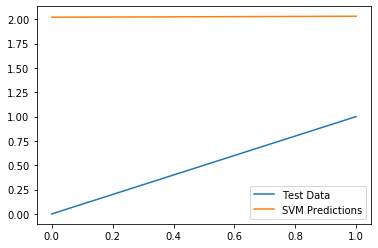

In [25]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

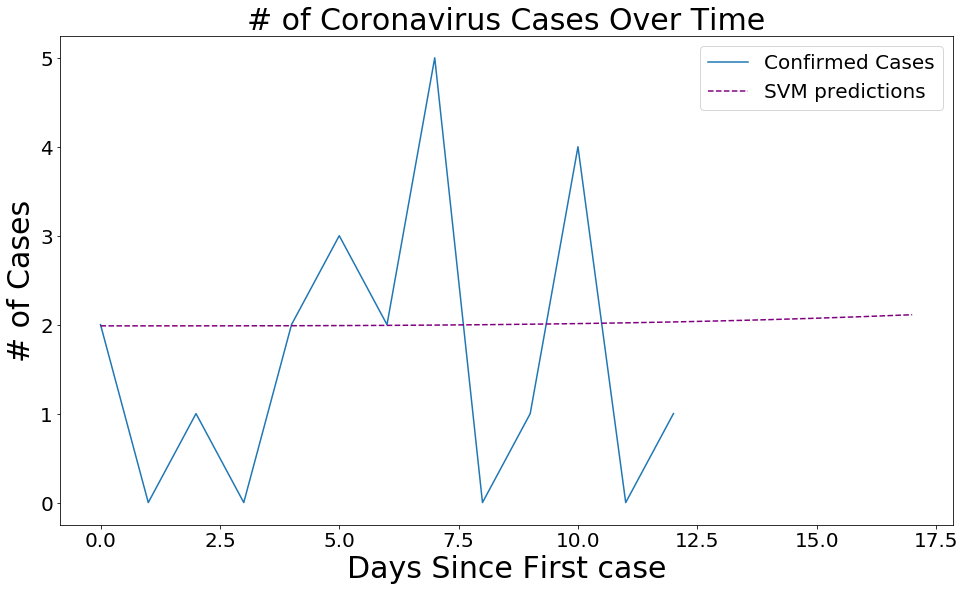

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, new_case)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since First case', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [34]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [38]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 30.280303030280038
MSE: 1111.414715333687


In [39]:
print(linear_model.coef_)

[[ 1.82692308 -0.92578671 -0.56534091  0.41834207 -0.06869172  0.00336538]]


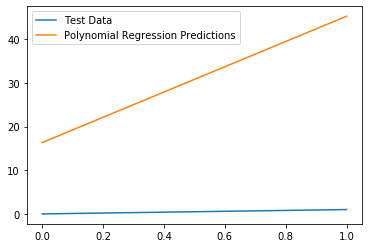

In [40]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

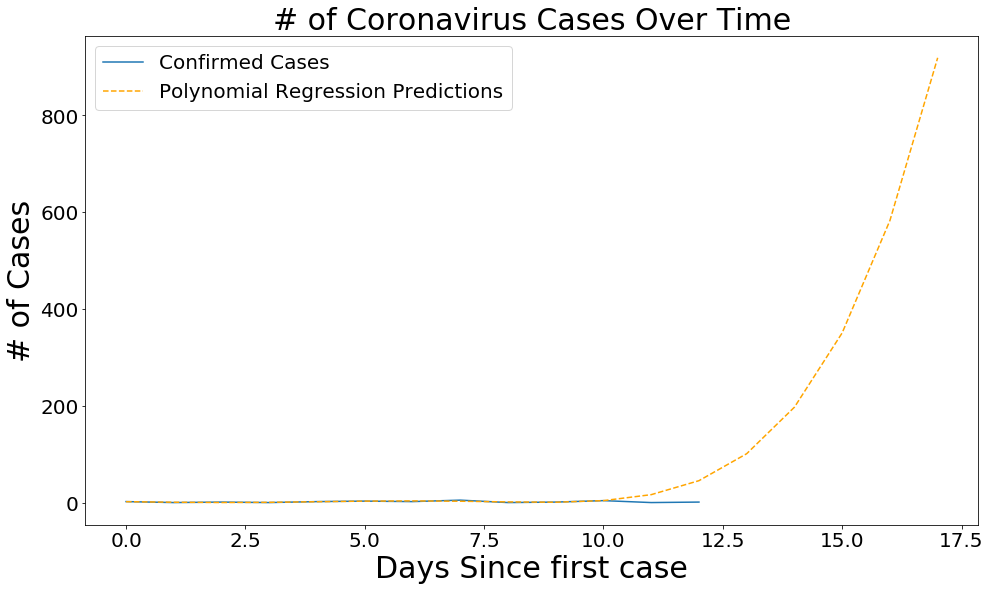

In [42]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, new_case)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since first case', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [43]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)
bayesian_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
/Users/hteza/opt/anaconda3/envs/Class/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-06,
 'alpha_2': 1e-07,
 'alpha_1': 1e-05}

In [44]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 1.7276606798815166
MSE: 3.0031453061000946


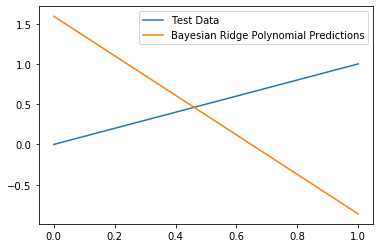

In [45]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

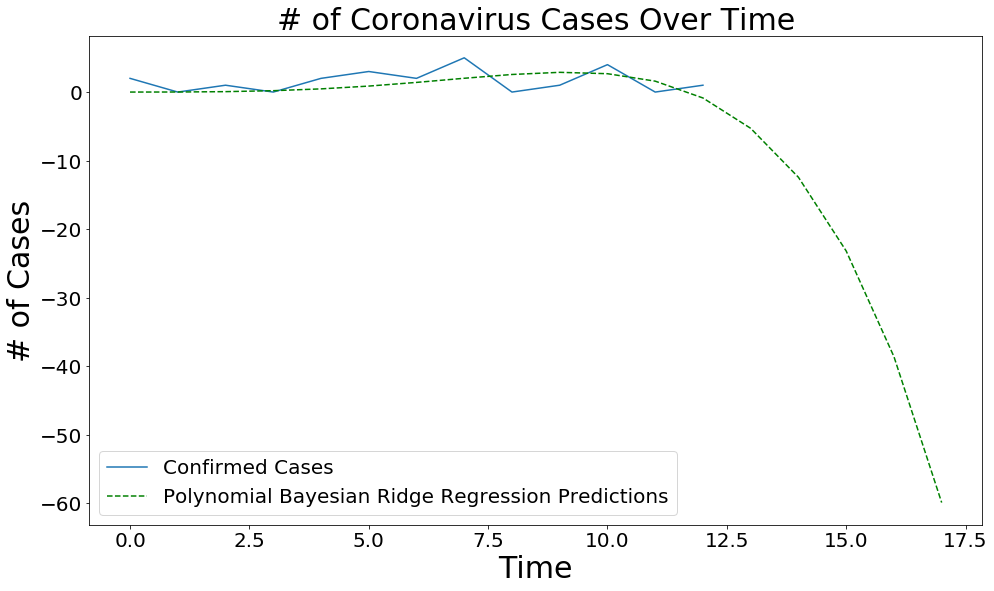

In [47]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, new_case)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()